In [23]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
import seaborn as sns
import numpy as np
import imageio
import cv2
import math
from tqdm.notebook import tqdm
# from Ellipse import Ellipse
from pure_detector.ellipse_utils import ellipse_distance

In [24]:
data = pd.concat([
    pd.read_pickle("eyeseg_benchmark.2d.pkl"),
#     pd.read_pickle("eyeseg_benchmark.2d.large.pkl"),
    pd.read_pickle("eyeseg_benchmark.pure_pfa.pkl"),
    pd.read_pickle("eyeseg_benchmark.pure_pfa_orig_canny.pkl"),
    pd.read_pickle("eyeseg_benchmark.pure_pfa_matlab_canny.gauss5.pkl"),
#     pd.read_pickle("eyeseg_benchmark.pure_pfa_orig_canny.matlab_canny.pkl"),
#     pd.read_pickle("eyeseg_benchmark.pure_pfa.large.pkl"),
    pd.read_pickle("eyeseg_benchmark.pure_orig.pkl"),
#     pd.read_pickle("eyeseg_benchmark.pure_orig.large.pkl"),
])
data.head()

,part,frame,time,method,target_center,target_axes,target_angle,confidence,center,axes,angle
0,1,0,0.011397,2d,"[80.8164291381836, 111.52066040039062]","[29.082298278808594, 31.568307876586914]",95.220924,0.0,"[0.0, 0.0]","[0.0, 0.0]",-90.0
1,1,1,0.001926,2d,"[77.20545959472656, 85.72146606445312]","[44.79753494262695, 46.851234436035156]",100.938171,0.0,"[0.0, 0.0]","[0.0, 0.0]",-90.0
2,1,2,0.001582,2d,"[77.080078125, 85.87702941894531]","[44.749420166015625, 46.97434997558594]",99.854988,0.0,"[0.0, 0.0]","[0.0, 0.0]",-90.0
3,1,3,0.001368,2d,"[77.02536010742188, 86.566162109375]","[45.09272766113281, 46.736873626708984]",99.447388,0.0,"[0.0, 0.0]","[0.0, 0.0]",-90.0
4,1,4,0.001322,2d,"[77.08142852783203, 87.5900650024414]","[44.7861213684082, 47.08686065673828]",103.696243,0.0,"[0.0, 0.0]","[0.0, 0.0]",-90.0


In [25]:
data["center_error"] = (data["target_center"] - data["center"]).apply(lambda val: np.linalg.norm(val))

In [26]:
methods = set(data["method"])
def method_iterator(data):
    for m in methods:
        yield m, data[data["method"] == m]

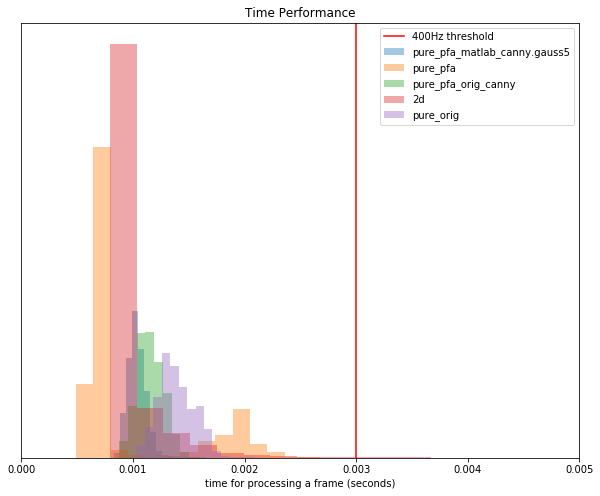

In [27]:
plt.figure(figsize=(10, 8))
plt.title("Time Performance")
for m, d in method_iterator(data):
    sns.distplot(d["time"], label=m, kde=False)
plt.xlim(0, 0.005)
plt.xlabel("time for processing a frame (seconds)")
plt.yticks([],[])
plt.axvline(x=0.003, color='r', label="400Hz threshold")
plt.legend()

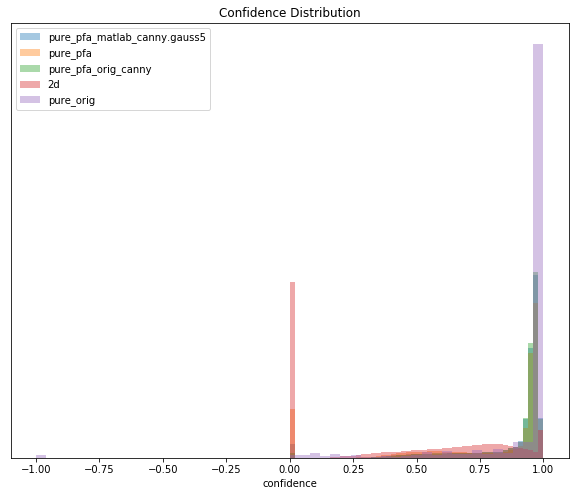

In [28]:
plt.figure(figsize=(10, 8))
plt.title("Confidence Distribution")
for m, d in method_iterator(data):
    sns.distplot(d["confidence"], label=m, kde=False)
plt.yticks([], [])
plt.legend()

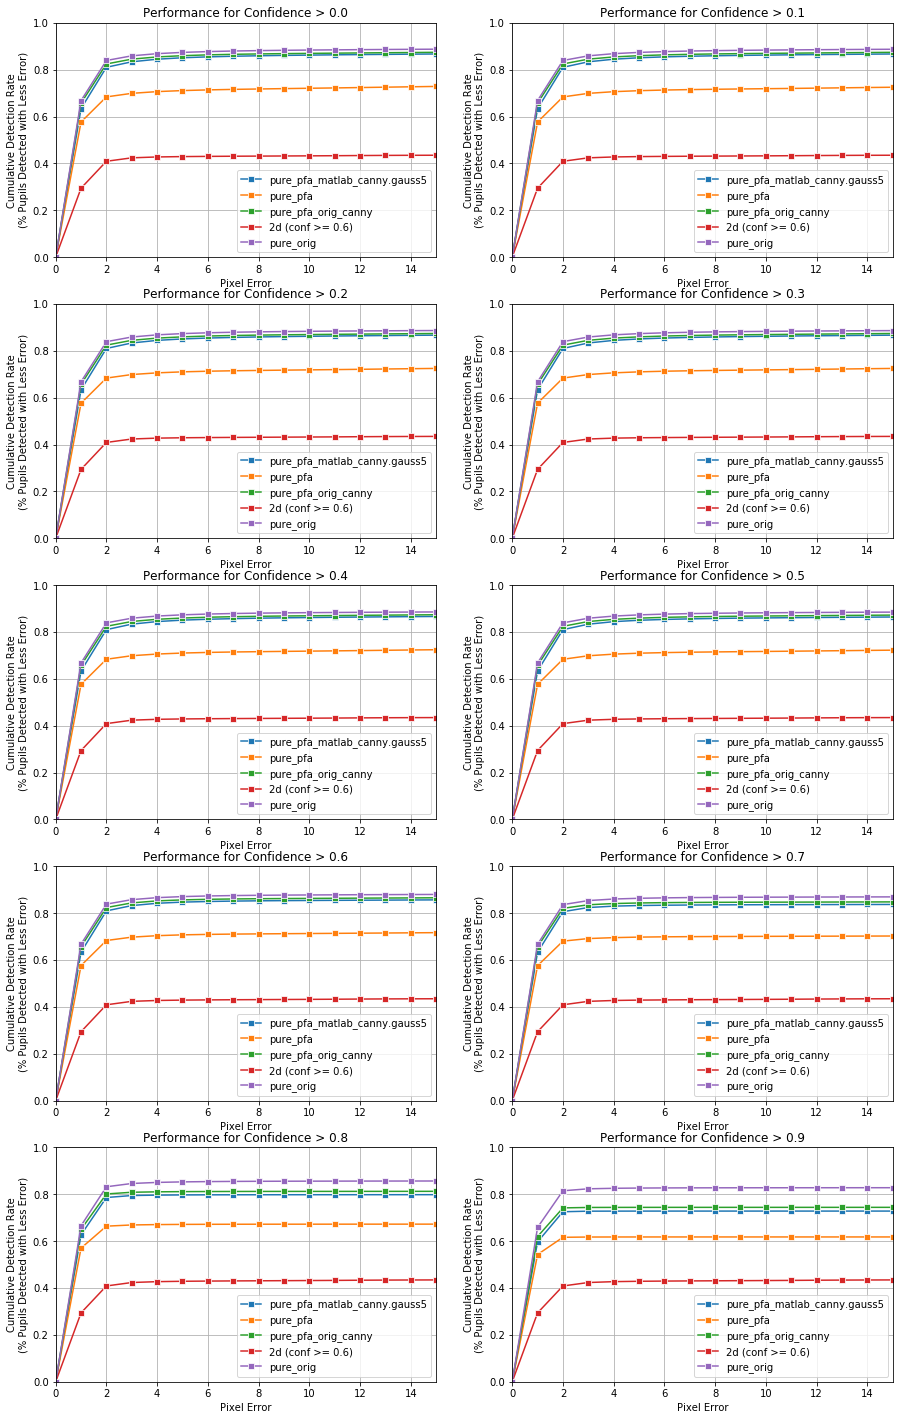

In [30]:
max_err = 16
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
axes = axes.reshape(-1)
for i, conf in enumerate(np.arange(0, 1, 0.1)):
    plt.sca(axes[i])
    plt.title(f"Performance for Confidence > {conf:.1f}")
    
    for m, d in method_iterator(data):
        c = conf if m != "2d" else 0.6
        label = m if m != "2d" else "2d (conf >= 0.6)"
        errors = d.loc[d["confidence"] >= c,"center_error"]
        errors_cum = errors.groupby(pd.cut(errors, bins=range(-1, max_err))).count().cumsum() / len(d)
        errors_cum = errors_cum.rename(columns=str).reset_index()[0]
        sns.lineplot(data=errors_cum, label=label, marker="s")
        
    plt.xlabel("Pixel Error")
    plt.ylabel("Cumulative Detection Rate\n(% Pupils Detected with Less Error)")
    plt.xlim(0, max_err-1)
    plt.ylim(0, 1)
    plt.grid()
plt.savefig("cmp.png")